# Formation du modèle

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('data_final.csv')

In [20]:
df.head()

,Name,Path,Target,x0,y0,z0,x1,y1,z1,x2,...,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20
0,A_000,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.229569,0.444634,-0.000014,0.266084,0.391483,-0.017858,0.293316,...,-0.023318,0.187018,0.260286,-0.044687,0.196690,0.304484,-0.043205,0.198647,0.313999,-0.027439
1,A_001,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.326145,0.457524,0.000023,0.356874,0.438809,-0.031042,0.384046,...,-0.035017,0.299476,0.338017,-0.056236,0.306872,0.371106,-0.060166,0.312788,0.375171,-0.054218
2,A_002,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.389025,0.445136,0.000024,0.425415,0.420819,-0.022708,0.456886,...,-0.032746,0.368978,0.306833,-0.048165,0.374945,0.342649,-0.054728,0.376168,0.347345,-0.054231
3,A_003,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.074114,0.572558,-0.000011,0.139794,0.579121,-0.042297,0.202413,...,-0.008108,0.097871,0.409136,-0.041117,0.093771,0.457411,-0.041635,0.100784,0.474702,-0.017104
4,A_004,C:\Users\utilisateur\Documents\microsoft_IA\Pr...,A,0.145682,0.324369,-0.000038,0.217293,0.309837,-0.016368,0.269147,...,0.003826,0.184741,0.124865,-0.022037,0.181261,0.173076,-0.031378,0.185656,0.193296,-0.011991


## Clean CSV

Nous commençons par supprimer les valeurs manquantes dans le csv.

In [21]:
df.isna().sum()

Name        0
Path        0
Target      0
x0        328
y0        328
         ... 
y19       328
z19       328
x20       328
y20       328
z20       328
Length: 66, dtype: int64

In [22]:
df.dropna(inplace=True)

## Train test split

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [24]:
X = df.iloc[:,3:]
y = df.iloc[:, 2]

enc = LabelEncoder()
y = enc.fit_transform(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(448, 63)
(24, 63)
(448,)
(24,)


# RandomForestClassifier

Pour le modèle nous utilisons deux méthodes, un split simple avec `train_test_split` et `StratifiedKFold` de sklearn, qui nous permet de répartir équitablement chaque classe dans nos train et test.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [27]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
print(skf)

for train_index, test_index in skf.split(X, y):
    X_train_2, X_test_2 = X.iloc[train_index], X.iloc[test_index]
    y_train_2, y_test_2 = y[train_index], y[test_index]

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


In [28]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

model_2 = RandomForestClassifier()
model_2.fit(X_train_2, y_train_2)

RandomForestClassifier()

### Evaluation du modèle

In [37]:
predictions = model.predict(X_test)
predictions_2 = model_2.predict(X_test_2)

In [38]:
print('Accuracy Model 1 : ', accuracy_score(y_test, predictions))
print('Accuracy Model 2 : ', accuracy_score(y_test_2, predictions_2))

Accuracy Model 1 :  0.5833333333333334
Accuracy Model 2 :  0.3601694915254237


Les modèles de forêts d'arbres décisionnels présentent des performances très moyennes avec une précision de **58** et **36%**. La méthode avec **StratifiedKFold** obtient un écart assez important de précision par rapport **train_test_split()**. Nous nous tournerons donc vers un réseau de neuronnes afin d'obtenir de meilleurs resultats. 

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<AxesSubplot:>

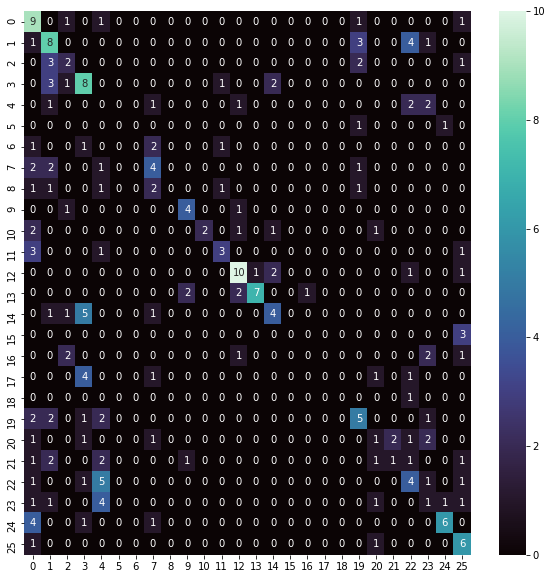

In [43]:
cm = confusion_matrix(y_test_2, predictions_2)
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap='mako', annot=True, fmt='d')

## Save Model

In [55]:
#import pickle

#pickle.dump(model_2, open('model_2.sav', 'wb'))

# ANN

In [44]:
import tensorflow as tf

In [69]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    mode='auto',
    save_best_only=True)


NUM_CLASSES = 26 # (nos 26 classes de lettes)

#Model Initialization
model_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input((63, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(120, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(60, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

#Compiling the Model
model_ann.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

#Model Fitting
history = model_ann.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=6,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback] # On garde le meilleur checkpoint d'epoch
)

Epoch 1/200
75/75 [==============================] - 2s 8ms/step - loss: 3.2804 - accuracy: 0.0565 - val_loss: 3.3199 - val_accuracy: 0.0417
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 3.1449 - accuracy: 0.0968 - val_loss: 3.1323 - val_accuracy: 0.0833
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 3.0454 - accuracy: 0.1146 - val_loss: 3.0356 - val_accuracy: 0.1667
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 2.9604 - accuracy: 0.1930 - val_loss: 2.9393 - val_accuracy: 0.1667
Epoch 5/200
75/75 [==============================] - 0s 4ms/step - loss: 2.7499 - accuracy: 0.2353 - val_loss: 2.8933 - val_accuracy: 0.1250
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 2.7291 - accuracy: 0.2159 - val_loss: 2.7560 - val_accuracy: 0.2083
Epoch 7/200
75/75 [==============================] - 0s 4ms/step - loss: 2.5689 - accuracy: 0.2810 - val_loss: 2.7929 - val_accuracy: 0.2917
Epoch 8/200
7

Epoch 59/200
75/75 [==============================] - 0s 3ms/step - loss: 1.6853 - accuracy: 0.4579 - val_loss: 1.9405 - val_accuracy: 0.6667
Epoch 60/200
75/75 [==============================] - 0s 3ms/step - loss: 1.8013 - accuracy: 0.4244 - val_loss: 1.9049 - val_accuracy: 0.5833
Epoch 61/200
75/75 [==============================] - 0s 3ms/step - loss: 1.6744 - accuracy: 0.5136 - val_loss: 1.9217 - val_accuracy: 0.6667
Epoch 62/200
75/75 [==============================] - 0s 2ms/step - loss: 1.6250 - accuracy: 0.5364 - val_loss: 1.8933 - val_accuracy: 0.7083
Epoch 63/200
75/75 [==============================] - 0s 2ms/step - loss: 1.6391 - accuracy: 0.5455 - val_loss: 1.9007 - val_accuracy: 0.7083
Epoch 64/200
75/75 [==============================] - 0s 2ms/step - loss: 1.6832 - accuracy: 0.4925 - val_loss: 1.8179 - val_accuracy: 0.6250
Epoch 65/200
75/75 [==============================] - 0s 2ms/step - loss: 1.5802 - accuracy: 0.5226 - val_loss: 1.8895 - val_accuracy: 0.5833
Epoch 

75/75 [==============================] - 0s 3ms/step - loss: 1.4243 - accuracy: 0.5665 - val_loss: 1.7046 - val_accuracy: 0.7083
Epoch 117/200
75/75 [==============================] - 0s 4ms/step - loss: 1.4332 - accuracy: 0.5415 - val_loss: 1.8608 - val_accuracy: 0.6250
Epoch 118/200
75/75 [==============================] - 0s 3ms/step - loss: 1.4913 - accuracy: 0.5228 - val_loss: 1.8281 - val_accuracy: 0.6250
Epoch 119/200
75/75 [==============================] - 0s 4ms/step - loss: 1.5255 - accuracy: 0.5575 - val_loss: 1.7239 - val_accuracy: 0.7083
Epoch 120/200
75/75 [==============================] - 0s 4ms/step - loss: 1.3709 - accuracy: 0.5957 - val_loss: 1.7817 - val_accuracy: 0.6250
Epoch 121/200
75/75 [==============================] - 0s 3ms/step - loss: 1.4122 - accuracy: 0.5430 - val_loss: 1.6994 - val_accuracy: 0.6667
Epoch 122/200
75/75 [==============================] - 0s 3ms/step - loss: 1.4165 - accuracy: 0.5541 - val_loss: 1.7773 - val_accuracy: 0.6667
Epoch 123/200

75/75 [==============================] - 0s 3ms/step - loss: 1.3389 - accuracy: 0.5689 - val_loss: 1.9730 - val_accuracy: 0.5833
Epoch 174/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3180 - accuracy: 0.5896 - val_loss: 1.7706 - val_accuracy: 0.6667
Epoch 175/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3876 - accuracy: 0.5325 - val_loss: 1.8746 - val_accuracy: 0.7083
Epoch 176/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3619 - accuracy: 0.5966 - val_loss: 1.8941 - val_accuracy: 0.6667
Epoch 177/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3923 - accuracy: 0.5542 - val_loss: 1.7882 - val_accuracy: 0.7083
Epoch 178/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3604 - accuracy: 0.5672 - val_loss: 1.8386 - val_accuracy: 0.7083
Epoch 179/200
75/75 [==============================] - 0s 3ms/step - loss: 1.3499 - accuracy: 0.5522 - val_loss: 1.8950 - val_accuracy: 0.6667
Epoch 180/200

In [70]:
model_ann.load_weights('model.h5')

## Score

In [74]:
prediction_ann = model_ann.predict(X_test)
prediction_ann = [pred.argmax() for pred in prediction_ann]

In [75]:
precision = accuracy_score(y_test, prediction_ann)
print("Précision du modèle :", precision*100, "%")

Précision du modèle : 70.83333333333334 %


Nous obtenons une précision de presque **71%**. Nous retiendrons donc ce model pour notre application de language des signes. 

<AxesSubplot:>

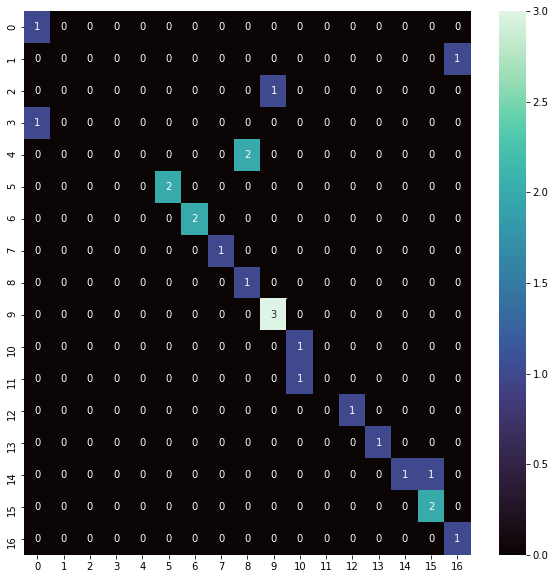

In [89]:
cm = confusion_matrix(y_test, prediction_ann)
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap='mako', annot=True, fmt='d')

## Courbes accuracy/loss

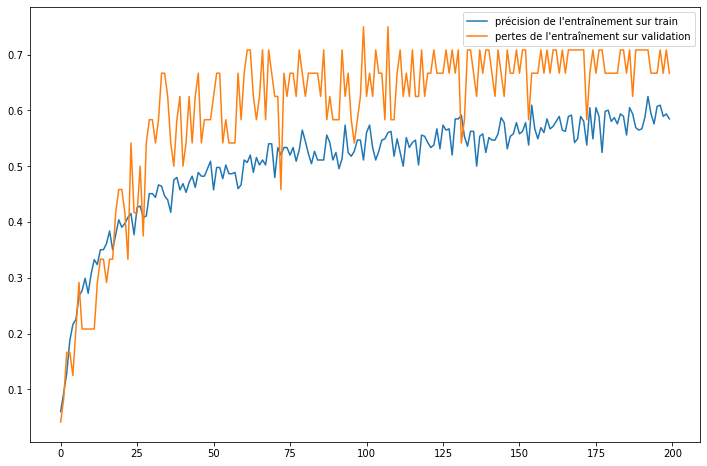

In [86]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],label="précision de l'entraînement sur train")
plt.plot(history.history['val_accuracy'],label="pertes de l'entraînement sur validation")
plt.legend()

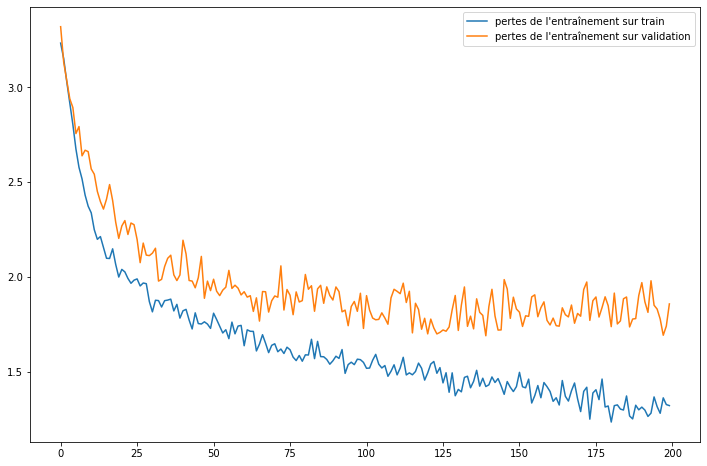

In [87]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],label="pertes de l'entraînement sur train")
plt.plot(history.history['val_loss'],label="pertes de l'entraînement sur validation")
plt.legend()

# Test Model

In [79]:
import mediapipe as mp
import cv2
from string import ascii_lowercase

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

dico = {k: v for k, v in enumerate(ascii_lowercase)}
print(dico)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [80]:
cap = cv2.VideoCapture(0)

#Initiate holistic model:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        #Recolor Feed
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #Make detection
        results = holistic.process(img)
        input_model = []
        
        try:
            coords = results.right_hand_landmarks.landmark
        
            for coord in coords:
                input_model.append(coord.x)
                input_model.append(coord.y)
                input_model.append(coord.z)
        
        except: pass
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        #Right hand
        mp_drawing.draw_landmarks(img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        
        try: 
            input_model = np.array(input_model).reshape(1, 63)
            #pred = model_2.predict(input_model)
            pred = model_ann.predict(input_model)
            pred = pred.argmax()
            img = cv2.putText(img, dico[pred],(250,450), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5)
        except: pass
        
        cv2.imshow('Test Mediapipe', img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()